### <span style="color:red">CONFIGURACIÓN: EJECUTAR UNA SOLA VEZ CUANDO SE INICIA EL COLAB.</span>

In [ ]:
!git clone https://github.com/mayala-afi/econometria-mf.git

%cd econometria-mf

!pip install -q -r requirements.txt

## SESIÓN 1 : MCO (OLS)

### Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
from utils import plot_resid, predict_plot

import statsmodels.api as sm

from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_breusch_godfrey

import warnings

warnings.filterwarnings("ignore")

### 1. Carga de datos

In [2]:
df = pd.read_stata("./data/base1.dta")

### 2. Crear fecha trimestral y declaración de serie temporal

In [3]:
df["year"] = df["time"].str.slice(0, 4).astype(int) # Extraemos el año
df["quarter"] = df["time"].str.slice(6, 7).astype(int) # Extraemos el trimestre

df["t"] = pd.PeriodIndex.from_fields(year=df["year"], quarter=df["quarter"], freq="Q") # Creamos la columna de fecha trimestral
df.set_index("t", inplace=True) # Pasamos la columna de fecha creada a índice

### 3. Limpieza y renombrado de variables

In [4]:
# Renombramos las variables a nombres en español
df.rename(
    columns={"gdp": "pib", "g_expenditure": "gasto", "g_revenue": "impuestos"},
    inplace=True,
)

# Eliminamos filas con valores no numéricos representados por ':'
clean_df = df[(df != ':').all(axis=1)]

# Aseguramos que las columnas sean de tipo numérico
clean_df["pib"] = pd.to_numeric(clean_df["pib"], errors='coerce')
clean_df["gasto"] = pd.to_numeric(clean_df["gasto"], errors='coerce')
clean_df["impuestos"] = pd.to_numeric(clean_df["impuestos"], errors='coerce')

### 4. _(Opcional)_ Transformaciones (log-diferencias)

Este paso debe realiazarse con df_no_nan para evitar errores al calcular logaritmos de valores no numéricos

In [5]:
# Transformaciones log-diferencias
clean_df["dpib"] = 100 * np.log(clean_df["pib"]).diff()
clean_df["dgasto"] = 100 * np.log(clean_df["gasto"]).diff()
clean_df["dimpuestos"] = 100 * np.log(clean_df["impuestos"]).diff()

# Eliminamos filas con NaN resultantes de las diferencias
clean_df = clean_df.dropna()

# Nos quedamos solo con las columnas necesarias para el análisis
clean_df = clean_df[["dpib", "dgasto", "dimpuestos"]]

In [6]:
# En este punto podemos revisar como queda el DataFrame limpio y transformado
clean_df.head()


,dpib,dgasto,dimpuestos
t,,,
1999Q2,1.139011,2.012059,1.396493
1999Q3,1.350679,-0.968796,1.618246
1999Q4,1.104785,2.601933,3.476584
2000Q1,1.566889,2.687008,0.827779
2000Q2,1.256890,0.158851,1.860213


### 5. Regresión MCO

In [7]:
Y = clean_df["dpib"]
X = clean_df[["dgasto", "dimpuestos"]]
X = sm.add_constant(X)  # Agregamos constante para el intercepto

ols_model = sm.OLS(Y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   dpib   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.579
Method:                 Least Squares   F-statistic:                     72.65
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           2.42e-20
Time:                        11:36:59   Log-Likelihood:                -201.19
No. Observations:                 105   AIC:                             408.4
Df Residuals:                     102   BIC:                             416.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0998      0.188      0.531      0.5

### 6. Diagnóstico de residuos



Breusch-Pagan test:
 - LM Statistic: 18.97883046547592
 - p-value: 7.564832701814002e-05


Breusch-Godfrey test:
 - LM Statistic: 3.1169574417704142
 - p-value: 0.538447172349628


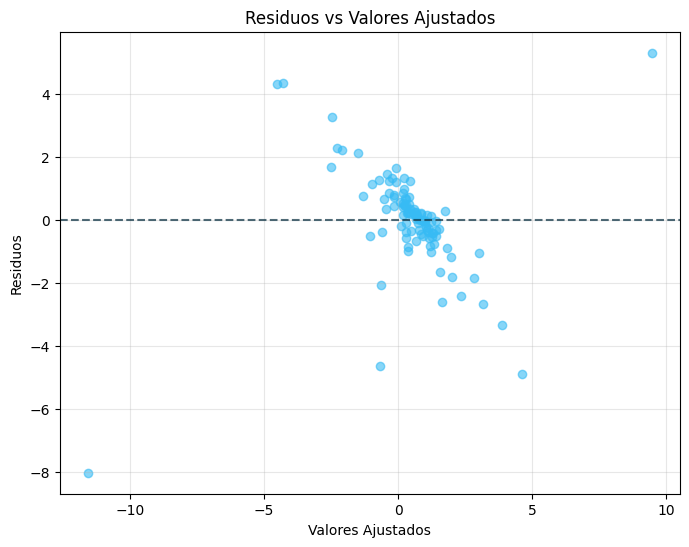

In [8]:
resid = ols_model.resid
fitted = ols_model.fittedvalues

# Heterocedasticidad
bp_test = het_breuschpagan(resid, X)
print("")
print(f"\nBreusch-Pagan test:\n - LM Statistic: {bp_test[0]}\n - p-value: {bp_test[1]}")

# Autocorrelación
bg_test = acorr_breusch_godfrey(ols_model, nlags=4)
print("")
print(f"\nBreusch-Godfrey test:\n - LM Statistic: {bg_test[0]}\n - p-value: {bg_test[1]}")

# Gráficos de diagnóstico de residuos
plot_resid(adj_vals=fitted, resids=resid)

### 7. Causalidad de Granger

_Nota: La hipótesis nula es que "dgasto no causa dpib"_

In [9]:
g_data = clean_df[["dpib", "dgasto"]]
var_model = VAR(g_data)
var_results = var_model.fit(maxlags=4) # Basado en el test de información AIC

print(var_results.test_causality("dpib", ["dgasto"], kind="f").summary())

Granger causality F-test. H_0: dgasto does not Granger-cause dpib. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
        0.4996          2.421   0.736 (4, 184)
----------------------------------------------


### 8. Predecir valores futuros

In [10]:
clean_df["yhat"] = ols_model.fittedvalues

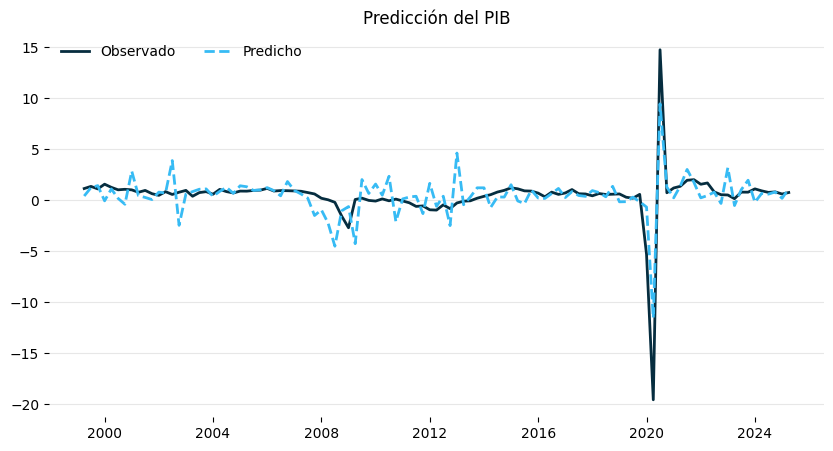

In [11]:
predict_plot(df = clean_df[["dpib", "yhat"]], title="Predicción del PIB")

#### _Notas:_
- _Asegúrate que las variables están correctamente ajustadas (precios constantes, series reales)_